# Exploratory data analisys
(Разведочный анализ данных)

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import StandardScaler

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [76]:
df = pd.read_csv('data/prices_train.csv')

In [77]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [78]:
len(df.columns)

81

# Смотрим на каждый признак в отдельности

## Что нас интересует?
- Тип (числовая / категориальная)
- Смысл
- Влияние на целевую переменную

В итоге анализа делаем __вывод__.

## Целевая переменная 

In [79]:
df['SalePrice'].describe()

count      1314.000000
mean     180656.219939
std       78781.415144
min       34900.000000
25%      130000.000000
50%      163950.000000
75%      214375.000000
max      755000.000000
Name: SalePrice, dtype: float64

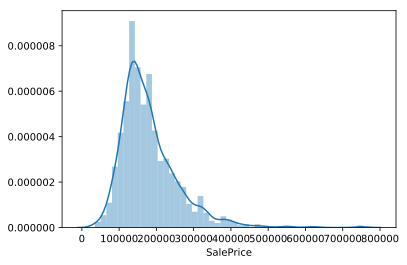

In [80]:
sns.distplot(df['SalePrice']);

In [81]:
print("Skewness: %f" % df['SalePrice'].skew())
print("Kurtosis: %f" % df['SalePrice'].kurt())

Skewness: 1.890060
Kurtosis: 6.902970


- Распределение отличается от нормального
- Коэффициент асимметрии > 0
- Коэффициент эксцесса (островершинности)  — мера остроты пика распределения случайной величины

## Зависимость целевой переменной от других признаков

### Тип: числовые

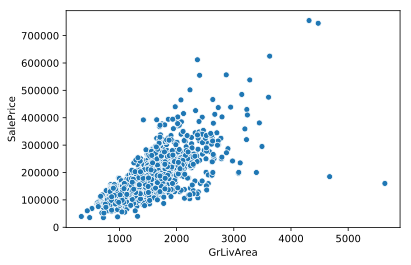

In [82]:
var = 'GrLivArea'
sns.scatterplot(x=df[var], y=df['SalePrice']);

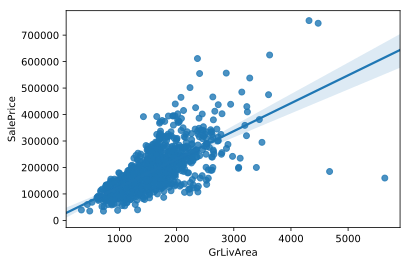

In [83]:
sns.regplot(x=df[var], y=df['SalePrice']);

Что видим?
- Смысл: Above grade (ground) living area square feet
- Зависимость: линейная

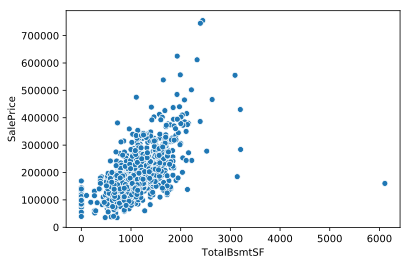

In [84]:
var = 'TotalBsmtSF'
sns.scatterplot(x=df[var], y=df['SalePrice']);

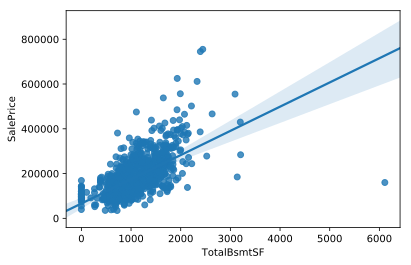

In [85]:
sns.regplot(x=df[var], y=df['SalePrice']);

Что видим?
- Total square feet of basement area
- Линейная зависимость

### Тип: категориальные

OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

In [86]:
var = 'OverallQual'
sorted(df[var].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

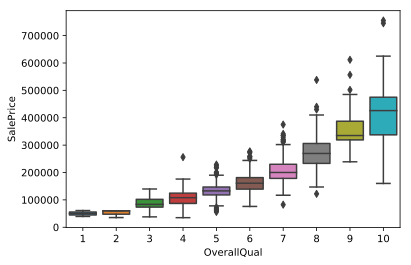

In [87]:
sns.boxplot(x=var, y="SalePrice", data=df);

Что видим?
- Сильная зависимость

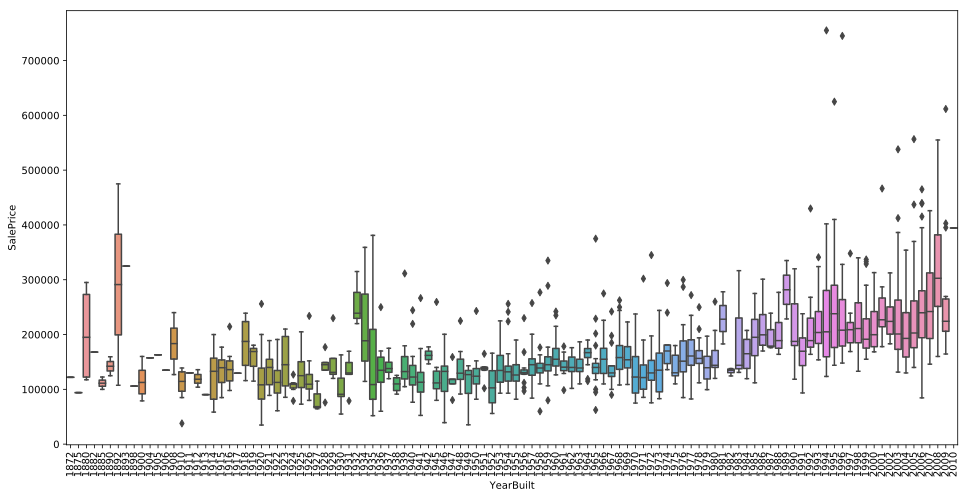

In [88]:
var = 'YearBuilt'
plt.subplots(figsize=(16, 8))
sns.boxplot(x=var, y="SalePrice", data=df);
plt.xticks(rotation=90);

Что видим?
- Есть зависимость, но не такая сильная
- В целом, чем новее дом, тем он в среднем дороже

### Выводы

- Линейная зависимость от TotalBsmtSF и GrLivArea
- Присутствует зависимость от YearBuilt и сильная зависимость от OverallQual

## Автоматизируем анализ

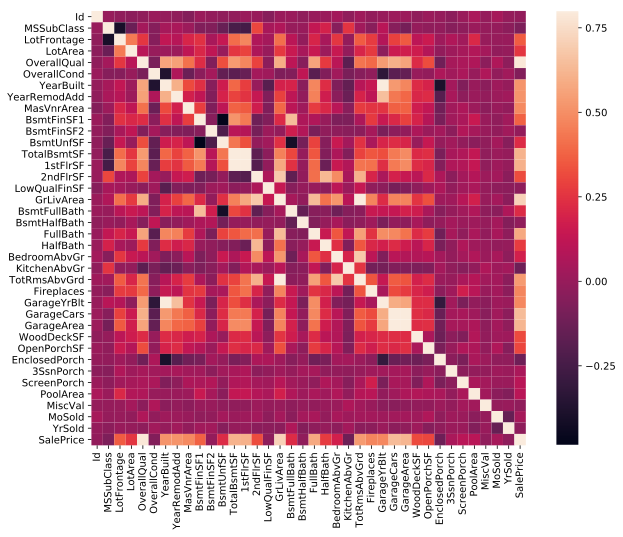

In [89]:
corrmat = df.corr()
plt.subplots(figsize=(11, 8))
sns.heatmap(corrmat, vmax=.8, square=True);

Что вижу?
- Признаки сильно коррелирующие с целевой переменной: OverallQual, GrLivArea, Garage..
- Возможно, мультиколлинеарность: GarageYrBlt-YearBlt, TotRmsAbvGrd-GrLivArea

Давай посмотрим на самые сильные признаки

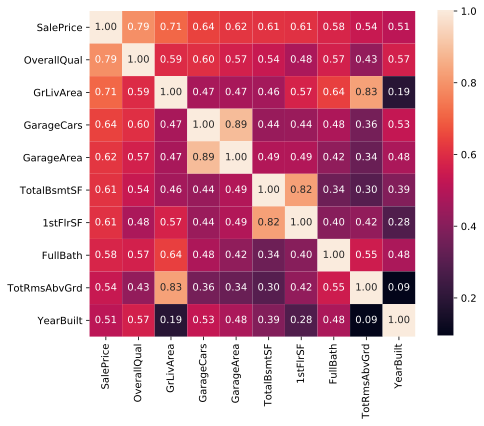

In [90]:
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
plt.subplots(figsize=(8, 6))
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values);

Что видим?

Давай построим pairplot для признаков с самой высокой корреляцией

In [91]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF']
sns.pairplot(df[cols], size = 2.5);

Что видим?
- Везде присутствует линейная зависимость и это нам на руку!

# Пропуски

О чем надо подумать?
- Насколько велика доля пропущенных значений?
- Есть ли какая-то закономерность в пропусках или они случайны?

In [92]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total   Percent
PoolQC         1307  0.994673
MiscFeature    1263  0.961187
Alley          1231  0.936834
Fence          1058  0.805175
FireplaceQu     620  0.471842
LotFrontage     233  0.177321
GarageType       74  0.056317
GarageCond       74  0.056317
GarageYrBlt      74  0.056317
GarageFinish     74  0.056317
GarageQual       74  0.056317
BsmtExposure     34  0.025875
BsmtFinType2     34  0.025875
BsmtFinType1     33  0.025114
BsmtCond         33  0.025114
BsmtQual         33  0.025114
MasVnrArea        7  0.005327
MasVnrType        7  0.005327
Exterior2nd       0  0.000000
Exterior1st       0  0.000000

- Очень много пропусков – удаляю признак (все что > 15%)
- GarageX, BsmntX, MasVnrX - отсутствуют неслучайно, есть паттерн

In [93]:
# df[missing_data.index[6:18]][df.BsmtCond.isnull()]

In [97]:
df = df.drop((missing_data[missing_data['Total'] > 10]).index,1)

In [98]:
df['MasVnrArea'].mean()

104.31216526396328

In [99]:
df['MasVnrType'].mode()[0]

'None'

In [100]:
df['MasVnrArea'].fillna(df['MasVnrArea'].mean(), inplace=True)
df['MasVnrType'] = df['MasVnrType'].fillna('None')

In [101]:
df.isnull().sum().max()

0

## Выбросы

### Target

In [102]:
saleprice_scaled = StandardScaler().fit_transform(df['SalePrice'].values.reshape(-1, 1));

In [103]:
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.85083898]
 [-1.84562003]
 [-1.81274444]
 [-1.79496698]
 [-1.78607826]
 [-1.63370008]
 [-1.62735098]
 [-1.59560553]
 [-1.58299624]
 [-1.55116189]]

outer range (high) of the distribution:
[[3.73763084]
 [3.86461266]
 [4.07841195]
 [4.5376163 ]
 [4.75348539]
 [4.77356121]
 [5.47292628]
 [5.64235812]
 [7.16613994]
 [7.29312176]]


In [104]:
round(saleprice_scaled.mean()), saleprice_scaled.std()

(-0.0, 1.0)

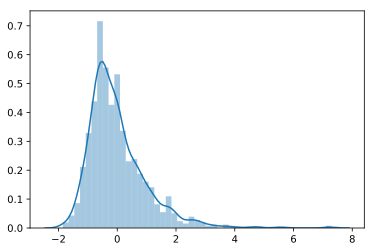

In [30]:
sns.distplot(saleprice_scaled);

### Bivariate analysis

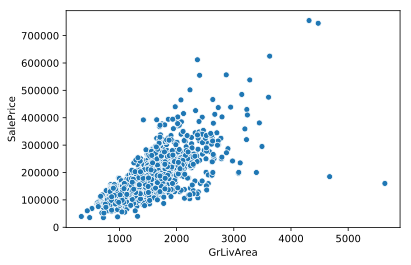

In [105]:
var = 'GrLivArea'
sns.scatterplot(x=df[var], y=df['SalePrice']);

In [106]:
df['GrLivArea'].sort_values(ascending = False)[:3]

884    5642
20     4676
990    4476
Name: GrLivArea, dtype: int64

In [107]:
df = df[df['GrLivArea'] < 4676]

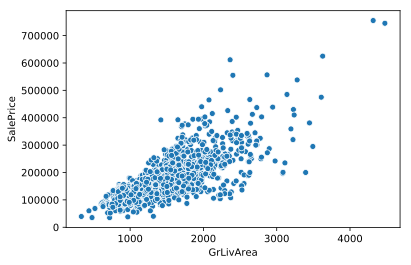

In [108]:
var = 'GrLivArea'
sns.scatterplot(x=df[var], y=df['SalePrice']);

## Hard core stuff

- Normality
- Linearity

### Normality

#### Target

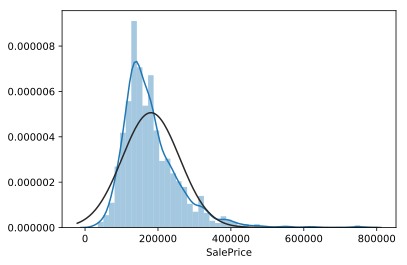

In [46]:
sns.distplot(df['SalePrice'], fit=stats.norm);

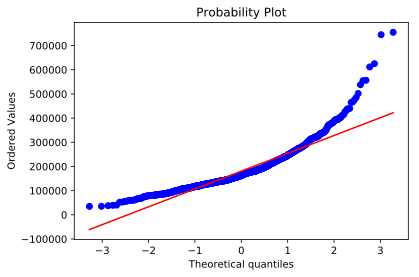

In [47]:
stats.probplot(df['SalePrice'], plot=plt);

__in case of positive skewness, log transformations usually works well__

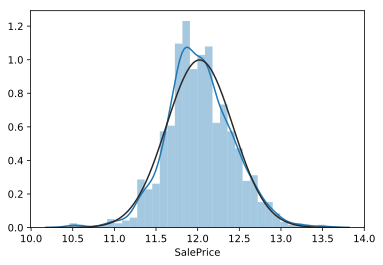

In [48]:
log_price = np.log(df['SalePrice'])
sns.distplot(log_price, fit=stats.norm);

In [49]:
print("Skewness: %f" % log_price.skew())
print("Kurtosis: %f" % log_price.kurt())

Skewness: 0.075215
Kurtosis: 0.842940


In [50]:
print("Skewness: %f" % log_price.skew())
print("Kurtosis: %f" % log_price.kurt())

Skewness: 0.075215
Kurtosis: 0.842940


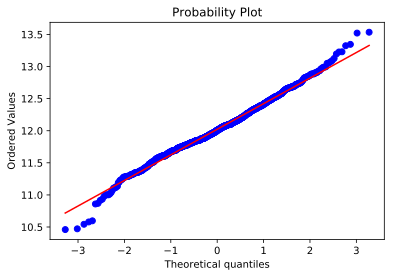

In [51]:
stats.probplot(log_price, plot=plt);

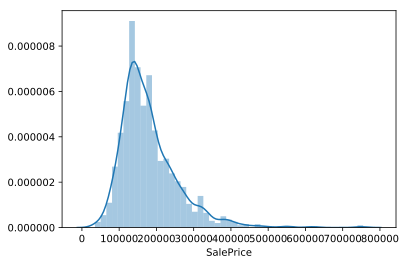

In [52]:
sns.distplot(np.exp(log_price));

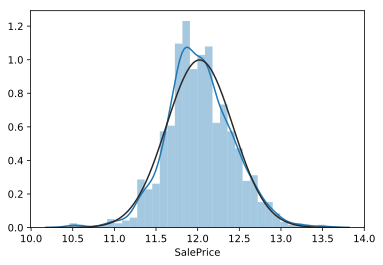

In [53]:
log_price = np.log(df['SalePrice'])
sns.distplot(log_price, fit=stats.norm);

#### Other

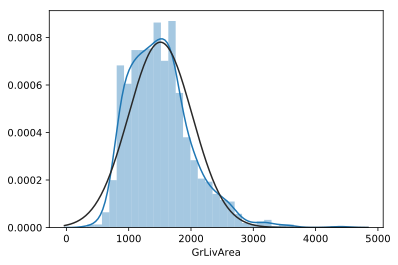

In [54]:
var = 'GrLivArea'
sns.distplot(df[var], fit=stats.norm);

In [55]:
print("Skewness: %f" % df[var].skew())
print("Kurtosis: %f" % df[var].kurt())

Skewness: 1.033890
Kurtosis: 2.210967


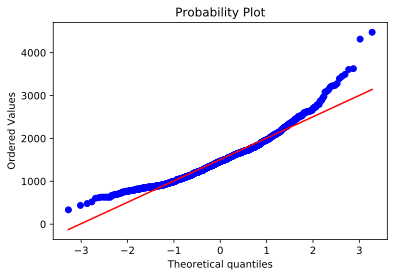

In [56]:
stats.probplot(df[var], dist='norm', plot=plt);

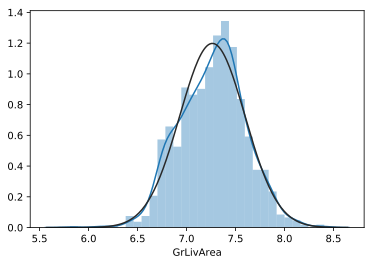

In [57]:
log_var = np.log(df[var])
sns.distplot(log_var, fit=stats.norm);

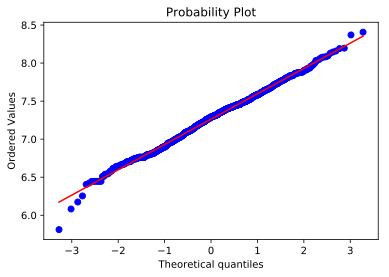

In [58]:
stats.probplot(log_var, dist='norm', plot=plt);

#### We've got a problem...

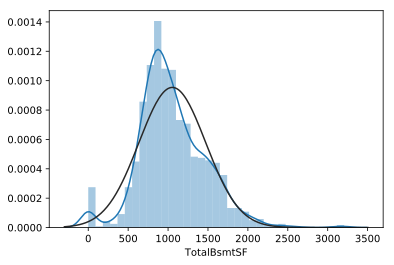

In [111]:
var = 'TotalBsmtSF'
sns.distplot(df[var], fit=stats.norm);

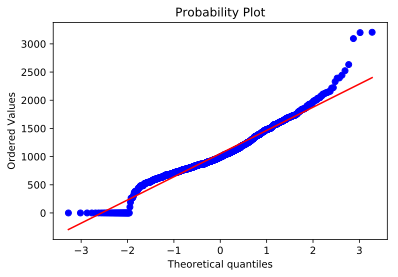

In [112]:
stats.probplot(df[var], dist='norm', plot=plt);

In [114]:
# problem here!
log_var = np.log(df[var]) 

In [115]:
log_var.value_counts().index[:2]

Float64Index([-inf, 6.761572768804055], dtype='float64')

In [116]:
log_var = np.log1p(df[var])

In [117]:
log_var.value_counts().index[:2]

Float64Index([0.0, 6.762729506931879], dtype='float64')

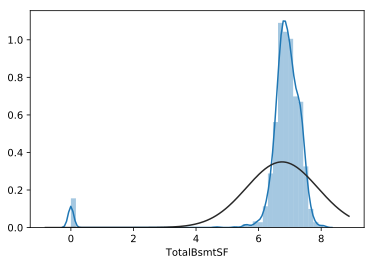

In [118]:
sns.distplot(log_var, fit=stats.norm);

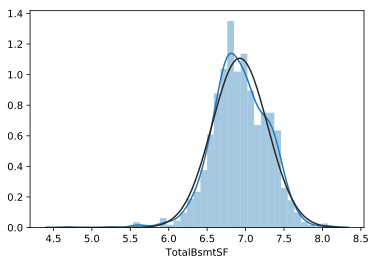

In [66]:
sns.distplot(log_var[log_var > 0], fit=stats.norm);

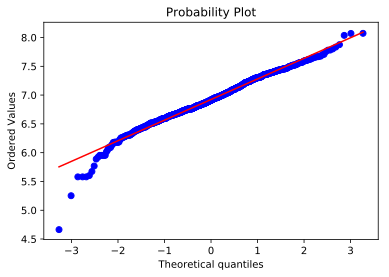

In [67]:
stats.probplot(log_var[log_var > 0], dist='norm', plot=plt);

In [68]:
df['HasBsmnt'] = (df['TotalBsmtSF'] > 0).astype(int)

## One-hot
Easy-peasy

In [69]:
df['SaleType'].head()

0     WD
1     WD
2     WD
3     WD
4    New
Name: SaleType, dtype: object

In [70]:
sorted(df['SaleType'].unique())

['COD', 'CWD', 'Con', 'ConLD', 'ConLI', 'ConLw', 'New', 'Oth', 'WD']

In [71]:
pd.get_dummies(df['SaleType']).head()

COD  CWD  Con  ConLD  ConLI  ConLw  New  Oth  WD
0    0    0    0      0      0      0    0    0   1
1    0    0    0      0      0      0    0    0   1
2    0    0    0      0      0      0    0    0   1
3    0    0    0      0      0      0    0    0   1
4    0    0    0      0      0      0    1    0   0

In [72]:
df = pd.get_dummies(df)

## Model

....